## FashionCLIP

In [8]:
import numpy as np
from transformers import CLIPProcessor, CLIPModel
import pandas as pd
import os

model = CLIPModel.from_pretrained("patrickjohncyh/fashion-clip")
processor = CLIPProcessor.from_pretrained("patrickjohncyh/fashion-clip")

def encode_text(inputText):
    input_vectors = processor(text=inputText, return_tensors="pt", max_length=77, padding="max_length", truncation=True)
    text_embedding = model.get_text_features(**input_vectors).detach().cpu().numpy()
    # text_embedding = text_embeddings[0].tolist()
    return text_embedding

def load_imgVector():
    if os.path.exists("./img_vectors.csv") == False :
        print("no such file")
        return None
        # download_imgvector()
    item_df = pd.read_csv("./item_df.csv")
    image_embeddings = np.loadtxt("./img_vectors.csv", delimiter=",")
    return item_df, image_embeddings

def get_top_five_similarity(query):
    # Encode the query text to get a text embedding
    text_embedding = encode_text(query)
    
    item_df, image_embeddings = load_imgVector()
    image_embeddings = image_embeddings/np.linalg.norm(image_embeddings, ord=2, axis=-1, keepdims=True)
    text_embedding = text_embedding/np.linalg.norm(text_embedding, ord=2, axis=-1, keepdims=True)
    
    similarities = np.dot(text_embedding, image_embeddings.T)

    id_sim_set = item_df[["id"]]
    id_sim_set = id_sim_set.assign(sim=similarities[0])

    id_sim_set.sort_values(by='sim', ascending=False, ignore_index=True, inplace=True)
    
    return np.array(id_sim_set["sim"][:5]).mean()

## translate queries with gpt

In [3]:
import sys
sys.path.append('../Backend/model/search')
from gpt import GPT

gpt = GPT()

query_type_list = ["abstract", "nonabstract"]
for query_type in query_type_list:
    line_num = 0
    with open(f"query/gpt-3.5-turbo-instruct-{query_type}.txt", "w") as gpt_file:
        with open(f"query/{query_type}.txt", "r") as file:
            queries = file.read().splitlines()
            for query in queries:
                line_num += 1
                response = gpt.get_response(query).choices[0].text.strip()
                gpt_file.write(f"{line_num}: {response}\n")

In [9]:
import re

sim_dict = {}
for type in ['abstract', 'nonabstract']:
    sim_list = []
    with open (f"query/{type}.txt", "r") as original_file, open(f'query/gpt-3.5-turbo-instruct-{type}.txt', 'r') as gpt_file:
        for original_line, gpt_line in zip(original_file, gpt_file):
            original_top_five_sim = get_top_five_similarity(original_line.strip())
            gpt_line = re.sub(r'\d{1,2}:', '', re.sub(r'\.', '', gpt_line.replace(", ", ","))).strip()
            gpt_line_list = gpt_line.split(',')
            del gpt_line_list[0] # delete the categorization result
            del gpt_line_list[-1] # delete the last query
            gpt_queries = gpt_line_list[:-1]
            gpt_top_five_sim = np.array([get_top_five_similarity(gpt_query) for gpt_query in gpt_queries]).mean()
            sim_list.append([original_line, gpt_queries, original_top_five_sim, gpt_top_five_sim])
    sim_dict[type] = sim_list

In [10]:
columns = ["Original Query", "GPT Queries", "Original Top Five Similarity", "GPT Top Five Similarity"]
abstract_sim_df = pd.DataFrame(sim_dict["abstract"], columns=columns)
nonabstract_sim_df = pd.DataFrame(sim_dict["nonabstract"], columns=columns)

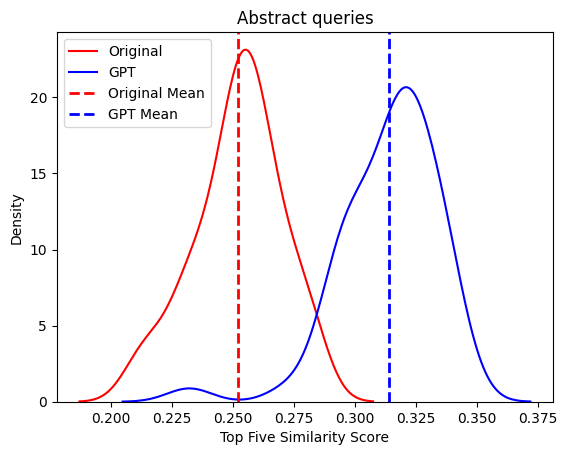

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

original_mean = np.mean(abstract_sim_df['Original Top Five Similarity'])
gpt_mean = np.mean(abstract_sim_df['GPT Top Five Similarity'])

org = sns.kdeplot(abstract_sim_df['Original Top Five Similarity'], color='red', label='Original')
gpt = sns.kdeplot(abstract_sim_df['GPT Top Five Similarity'], color='blue', label='GPT')

org.axvline(original_mean, color='red', linestyle='dashed', linewidth=2, label='Original Mean')
gpt.axvline(gpt_mean, color='blue', linestyle='dashed', linewidth=2, label='GPT Mean')

# Display the combined legend
plt.legend()

# plt.legend(labels=['original', 'gpt'])
plt.xlabel('Top Five Similarity Score')
plt.title("Abstract queries")
plt.savefig('figures/abstract_top_five_sim.jpg')
plt.show()


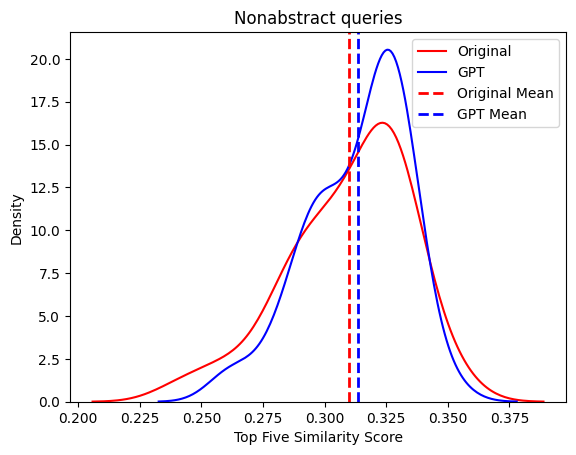

In [16]:
original_mean = np.mean(nonabstract_sim_df['Original Top Five Similarity'])
gpt_mean = np.mean(nonabstract_sim_df['GPT Top Five Similarity'])

org = sns.kdeplot(nonabstract_sim_df['Original Top Five Similarity'], color='red', label='Original')
gpt = sns.kdeplot(nonabstract_sim_df['GPT Top Five Similarity'], color='blue', label='GPT')

org.axvline(original_mean, color='red', linestyle='dashed', linewidth=2, label='Original Mean')
gpt.axvline(gpt_mean, color='blue', linestyle='dashed', linewidth=2, label='GPT Mean')

plt.legend()
plt.xlabel('Top Five Similarity Score')
plt.title("Nonabstract queries")
plt.savefig('figures/nonabstract_top_five_sim.jpg')
plt.show()